In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

from tensorflow.keras.datasets import cifar10

In [2]:
tf.random.set_seed(5)
np.random.seed(5)

In [80]:
workbook = xlsxwriter.Workbook('vanish_measurements.xlsx')
worksheet = workbook.add_worksheet("vanish test")
sp = [1]

In [81]:
def save_data(name, initial, one_e, ten_e):    
    worksheet.write(1, sp[0], name)
    worksheet.write(2, sp[0], "initial")
    worksheet.write(3, sp[0], "1st epoch")
    worksheet.write(4, sp[0], "Cumulative change")
    worksheet.write(5, sp[0], "10th epoch")
    worksheet.write(6, sp[0], "Cumulative change")
    
    sp[0] += 1
    
    for i in range(len(initial)):
        worksheet.write(2, sp[0]+i, initial[i])
        worksheet.write(3, sp[0]+i, one_e[i])
        worksheet.write(4, sp[0]+i, np.abs(one_e[i] - initial[i]))
        worksheet.write(4, sp[0]+i+1, np.sum(np.abs(one_e[:] - initial[:])))
        worksheet.write(5, sp[0]+i, ten_e[i])
        worksheet.write(6, sp[0]+i, np.abs(ten_e[i] - initial[i]))
        worksheet.write(6, sp[0]+i+1, np.sum(np.abs(ten_e[:] - initial[:])))
        
    sp[0] += len(initial)+2

In [6]:
class AdaptiveLayer(keras.layers.Layer):
    
    def __init__(self, units, structure=[2, 2], inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        if structure[-1] != 1:
            self.structure.append(1)
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        
        
    def build(self, input_shape):
        self.outer_w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal")
        self.outer_b = self.add_weight(shape=(self.units), initializer="zeros")
        
        self.inner_w = []
        self.inner_b = []
        for i in range(len(self.structure)):
            if i == 0:
                self.inner_w.append(self.add_weight(shape=(self.units, 1, self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=1.5)))
            else:
                self.inner_w.append(self.add_weight(shape=(self.units, self.structure[i-1], self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=0.9)))
            
            self.inner_b.append(self.add_weight(shape=(self.units, 1, self.structure[i]), initializer="zeros"))
   

    def call(self, inputs):
        z = inputs @ self.outer_w + self.outer_b
        a = tf.expand_dims(tf.transpose(z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a+z*self.skip_w)
        
        return a
        

    def activation_show(self, inputs):
        inner_z = tf.cast(tf.expand_dims(tf.transpose(inputs), axis=-1), dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(inner_z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a)
        
        return a

In [7]:
class AdaptiveLayerConv(keras.layers.Layer):
    
    def __init__(self, units, structure=[4, 8], split=2, inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.9, noise=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        self.split = split
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        self.noise = noise
        
        
    def build(self, input_shape):
        
        self.outer_w = []
        self.outer_b = []
        
        for i in range(0, self.split):
            self.outer_w.append(self.add_weight(shape=(input_shape[-1], self.units), 
                                                 initializer="random_normal"))
            self.outer_b.append(self.add_weight(shape=(self.units), initializer="zeros"))
        
        self.inner_conv = []
        for i in range(0, len(self.structure)):
            self.inner_conv.append(keras.layers.Conv1D(self.structure[i], 1, 
                                                       activation=self.inner_hidden_activation))
            
        self.inner_conv.append(keras.layers.AveragePooling1D(pool_size=self.split, data_format='channels_first'))      
        self.inner_conv.append(keras.layers.Conv1D(self.units, 1)) 

   

    def call(self, inputs):
        z = []
        for i in range(0, self.split):
            noise = tf.random.truncated_normal(shape=(self.outer_b[i].shape))
            z.append(inputs @ self.outer_w[i] + self.outer_b[i] + noise*self.noise)
        
        a = tf.cast(z, dtype=tf.float32)
        z = tf.cast(z, dtype=tf.float32)
        
        for i in range(len(self.inner_conv)-2):
            a = self.inner_conv[i](a)
        
        a = self.inner_conv[len(self.inner_conv)-2](tf.transpose(a))
        a = self.inner_conv[len(self.inner_conv)-1](tf.transpose(a))
    
        a = tf.reshape(a, shape=(-1, self.units))
        z_skip = tf.reduce_sum(z, axis=0)/self.split     
        
        a = self.inner_out_activation(a + z_skip*self.skip_w)
        
        return a    

    def activation_show(self, inputs):
        tmp = []
        for i in range(0, self.units):
            tmp.append(inputs)
        
        tmp = tf.cast(tmp, dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(tmp), axis=0)
            
        for i in range(len(self.inner_conv)-2):
            a = self.inner_conv[i](a)
             
        a = self.inner_conv[len(self.inner_conv)-1](a)
        a = tf.reshape(a, shape=(-1, self.units))
        a = self.inner_out_activation(a)
        
        return a
        


In [8]:
class AdaptiveModel(keras.Model):
    
    def __init__(self, l=[AdaptiveLayer(2), AdaptiveLayer(1)]):
        super().__init__()
        self.l = l

    def call(self, inputs):
        a = inputs
        for layer in self.l:
            a = layer(a)
        
        return a
        
    def activation_show(self, inputs):
        y = []
        
        for layer in self.l:
            tmp = layer.activation_show(inputs)
            
            for i in range(tmp.shape[-1]):
                y.append(tmp[:, i])
        
        return y
        

In [9]:
# dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [10]:
static_f_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(3072, )),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [11]:
adaptive_f_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(3072, )),
    keras.layers.Dense(100, activation=tf.nn.swish),
    keras.layers.Dense(50, activation=tf.nn.swish),
    keras.layers.Dense(40, activation=tf.nn.swish),
    keras.layers.Dense(20, activation=tf.nn.swish),
    keras.layers.Dense(20, activation=tf.nn.swish),
    keras.layers.Dense(10, activation=tf.nn.swish),
    keras.layers.Dense(10, activation="softmax"),
])

In [65]:
# Adaptive Layer (skip_connection-on)
adaptive_nn_model = AdaptiveModel([
    keras.layers.InputLayer(input_shape=(3072, )),
    AdaptiveLayer(100, structure=[2, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=1.9), 
    AdaptiveLayer(50, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=1.3), 
    AdaptiveLayer(40, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=1.3), 
    AdaptiveLayer(20, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=1.1),
    AdaptiveLayer(20, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0.9), 
    AdaptiveLayer(10, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0.9), 
    AdaptiveLayer(10, structure=[8, 4, 1], inner_hidden_activation=tf.nn.relu, 
                 inner_out_activation=tf.nn.softmax, skip_w=0.9)
])

In [43]:
# Adaptive Layer (skip_connection-off)
adaptive_nn_model_noskip = AdaptiveModel([
    keras.layers.InputLayer(input_shape=(3072, )),
    AdaptiveLayer(100, structure=[2, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0), 
    AdaptiveLayer(50, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0), 
    AdaptiveLayer(40, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0), 
    AdaptiveLayer(20, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0),
    AdaptiveLayer(20, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0), 
    AdaptiveLayer(10, structure=[4, 4, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0), 
    AdaptiveLayer(10, structure=[8, 4, 1], inner_hidden_activation=tf.nn.relu, 
                 inner_out_activation=tf.nn.softmax, skip_w=0)
])

In [44]:
# Adaptive Layer based on 1D Conv (skip_connection-on)
adaptive_conv_nn_model = AdaptiveModel([
    keras.layers.InputLayer(input_shape=(3072, )),
    AdaptiveLayerConv(100, structure=[32], split=1, noise=0, skip_w=1.9, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu), 
    AdaptiveLayerConv(50, structure=[64], split=2, noise=0, skip_w=1.3, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(40, structure=[64], split=2, noise=0, skip_w=1.3, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(20, structure=[64], split=2, noise=0, skip_w=1.1, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(20, structure=[64], split=2, noise=0, skip_w=0.9, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(10, structure=[64], split=2, noise=0, skip_w=0.9, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(10, structure=[128], split=3, noise=0, skip_w=0.9, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.softmax) 
])

In [45]:
# Adaptive Layer based on 1D Conv (skip_connection-off)
adaptive_conv_nn_model_noskip = AdaptiveModel([
    keras.layers.InputLayer(input_shape=(3072, )),
    AdaptiveLayerConv(100, structure=[32], split=1, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu), 
    AdaptiveLayerConv(50, structure=[64], split=2, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(40, structure=[64], split=2, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(20, structure=[64], split=2, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(20, structure=[64], split=2, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(10, structure=[64], split=2, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.leaky_relu),
    AdaptiveLayerConv(10, structure=[128], split=3, noise=0, skip_w=0, 
                      inner_hidden_activation=tf.nn.leaky_relu, inner_out_activation=tf.nn.softmax) 
])

In [66]:
tmp = adaptive_nn_model.predict(x_test)
tmp = adaptive_conv_nn_model.predict(x_test)
tmp = adaptive_nn_model_noskip.predict(x_test)
tmp = adaptive_conv_nn_model_noskip.predict(x_test)

313/313 [==============================] - 1s 1ms/step


In [67]:
# initial_static_f_model_w = static_f_model.weights[0][0, 0:10]
# initial_adaptive_f_model_w = adaptive_f_model.weights[0][0, 0:10]
initial_adaptive_nn_model_w = adaptive_nn_model.weights[0][0, 0:10]
# initial_adaptive_conv_nn_model_w = adaptive_conv_nn_model.weights[0][0, 0:10]
# initial_adaptive_nn_model_w_noskip = adaptive_nn_model_noskip.weights[0][0, 0:10]
# initial_adaptive_conv_nn_model_w_noskip = adaptive_conv_nn_model_noskip.weights[0][0, 0:10]

In [18]:
print("Initial\nStatic fun :", initial_static_f_model_w, "\nAdaptive fun : ", initial_adaptive_f_model_w, 
      "\nAdaptive NN : ", initial_adaptive_nn_model_w, "\nAdaptive Conv NN : ", initial_adaptive_conv_nn_model_w,
      "\nAdaptive NN (no skip): ", initial_adaptive_nn_model_w_noskip, 
      "\nAdaptive Conv NN (no skip): ", initial_adaptive_conv_nn_model_w_noskip)

Initial
Static fun : tf.Tensor(
[-0.02639575  0.03312974 -0.00521431 -0.01736678  0.04001208  0.03889133
 -0.03063603  0.01337568 -0.01033268 -0.02156243], shape=(10,), dtype=float32) 
Adaptive fun :  tf.Tensor(
[-0.01111929  0.02480051 -0.03394404  0.03879064 -0.00428951  0.00850152
  0.00739829  0.04054184 -0.01352848  0.03779843], shape=(10,), dtype=float32) 
Adaptive NN :  tf.Tensor(
[ 0.04076729 -0.03476807 -0.07974146  0.04353393  0.00626314 -0.09546327
  0.1415981  -0.06426024 -0.03710301 -0.03714851], shape=(10,), dtype=float32) 
Adaptive Conv NN :  tf.Tensor(
[ 0.03704462  0.04567838 -0.04318453  0.07491991  0.04731445 -0.02023408
 -0.05866965 -0.06612662  0.02800447  0.0218181 ], shape=(10,), dtype=float32) 
Adaptive NN (no skip):  tf.Tensor(
[-0.0192234  -0.01829169 -0.01616429  0.1061985  -0.02222374 -0.09139032
  0.08440258 -0.01981097 -0.02532266  0.00219273], shape=(10,), dtype=float32) 
Adaptive Conv NN (no skip):  tf.Tensor(
[ 0.00452195 -0.00524835 -0.026572   -0.0599

In [19]:
static_f_model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [20]:
adaptive_f_model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [68]:
adaptive_nn_model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [49]:
adaptive_conv_nn_model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [50]:
adaptive_nn_model_noskip.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [51]:
adaptive_conv_nn_model_noskip.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [69]:
EPOCHS = 1

In [26]:
static_f_model.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 2s 1ms/step - loss: 2.0504 - accuracy: 0.2129


In [27]:
adaptive_f_model.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 2s 1ms/step - loss: 1.9556 - accuracy: 0.2736


In [70]:
adaptive_nn_model.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 4s 2ms/step - loss: 2.0914 - accuracy: 0.1914


In [54]:
adaptive_conv_nn_model.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 8s 4ms/step - loss: 2.0738 - accuracy: 0.1836


In [55]:
adaptive_nn_model_noskip.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 4s 2ms/step - loss: 2.1458 - accuracy: 0.1623


In [56]:
adaptive_conv_nn_model_noskip.fit(x_train, y_train, epochs=EPOCHS)

1563/1563 [==============================] - 8s 4ms/step - loss: 2.3030 - accuracy: 0.0991


In [71]:
# one_e_static_f_model_w = static_f_model.weights[0][0, 0:10]
# one_e_adaptive_f_model_w = adaptive_f_model.weights[0][0, 0:10]
one_e_adaptive_nn_model_w = adaptive_nn_model.weights[0][0, 0:10]
# one_e_adaptive_conv_nn_model_w = adaptive_conv_nn_model.weights[0][0, 0:10]
# one_e_adaptive_nn_model_w_noskip = adaptive_nn_model_noskip.weights[0][0, 0:10]
# one_e_adaptive_conv_nn_model_w_noskip = adaptive_conv_nn_model_noskip.weights[0][0, 0:10]

In [72]:
EPOCHS = 9

In [34]:
static_f_model.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8264 - accuracy: 0.3340
Epoch 2/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7314 - accuracy: 0.3703
Epoch 3/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6802 - accuracy: 0.3936
Epoch 4/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6470 - accuracy: 0.4049
Epoch 5/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6239 - accuracy: 0.4132
Epoch 6/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5989 - accuracy: 0.4216
Epoch 7/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5814 - accuracy: 0.4285
Epoch 8/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5680 - accuracy: 0.4373
Epoch 9/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5510 - accuracy: 0.4436


In [35]:
adaptive_f_model.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7677 - accuracy: 0.3554
Epoch 2/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6807 - accuracy: 0.3926
Epoch 3/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6236 - accuracy: 0.4115
Epoch 4/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5850 - accuracy: 0.4302
Epoch 5/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5576 - accuracy: 0.4404
Epoch 6/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5324 - accuracy: 0.4477
Epoch 7/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5133 - accuracy: 0.4565
Epoch 8/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4968 - accuracy: 0.4614
Epoch 9/9
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4776 - accuracy: 0.4709


In [73]:
adaptive_nn_model.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8579 - accuracy: 0.3042
Epoch 2/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7592 - accuracy: 0.3564
Epoch 3/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6790 - accuracy: 0.3923
Epoch 4/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6223 - accuracy: 0.4136
Epoch 5/9
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5822 - accuracy: 0.4283
Epoch 6/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5490 - accuracy: 0.4415
Epoch 7/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5182 - accuracy: 0.4512
Epoch 8/9
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4946 - accuracy: 0.4637
Epoch 9/9
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4719 - accuracy: 0.4699


In [60]:
adaptive_conv_nn_model.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 7s 5ms/step - loss: 1.9090 - accuracy: 0.2637
Epoch 2/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7924 - accuracy: 0.3201
Epoch 3/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7223 - accuracy: 0.3551
Epoch 4/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6575 - accuracy: 0.3913
Epoch 5/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6043 - accuracy: 0.4186
Epoch 6/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5678 - accuracy: 0.4334
Epoch 7/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5360 - accuracy: 0.4456
Epoch 8/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5098 - accuracy: 0.4564
Epoch 9/9
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4839 - accuracy: 0.4674


In [61]:
adaptive_nn_model_noskip.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 4s 2ms/step - loss: 2.0372 - accuracy: 0.1914
Epoch 2/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9962 - accuracy: 0.2005
Epoch 3/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9698 - accuracy: 0.2149
Epoch 4/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9142 - accuracy: 0.2582
Epoch 5/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8167 - accuracy: 0.3121
Epoch 6/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7655 - accuracy: 0.3380
Epoch 7/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7144 - accuracy: 0.3624
Epoch 8/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6735 - accuracy: 0.3830
Epoch 9/9
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6453 - accuracy: 0.3964


In [62]:
adaptive_conv_nn_model_noskip.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3030 - accuracy: 0.0991
Epoch 2/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3029 - accuracy: 0.0977
Epoch 3/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3030 - accuracy: 0.0988
Epoch 4/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3029 - accuracy: 0.1009
Epoch 5/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3029 - accuracy: 0.0970
Epoch 6/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3029 - accuracy: 0.0998
Epoch 7/9
1563/1563 [==============================] - 7s 5ms/step - loss: 2.1469 - accuracy: 0.1598
Epoch 8/9
1563/1563 [==============================] - 8s 5ms/step - loss: 2.0291 - accuracy: 0.2061
Epoch 9/9
1563/1563 [==============================] - 7s 5ms/step - loss: 1.9912 - accuracy: 0.2299


In [74]:
# ten_e_static_f_model_w = static_f_model.weights[0][0, 0:10]
# ten_e_adaptive_f_model_w = adaptive_f_model.weights[0][0, 0:10]
ten_e_adaptive_nn_model_w = adaptive_nn_model.weights[0][0, 0:10]
# ten_e_adaptive_conv_nn_model_w = adaptive_conv_nn_model.weights[0][0, 0:10]
# ten_e_adaptive_nn_model_w_noskip = adaptive_nn_model_noskip.weights[0][0, 0:10]
# ten_e_adaptive_conv_nn_model_w_noskip = adaptive_conv_nn_model_noskip.weights[0][0, 0:10]

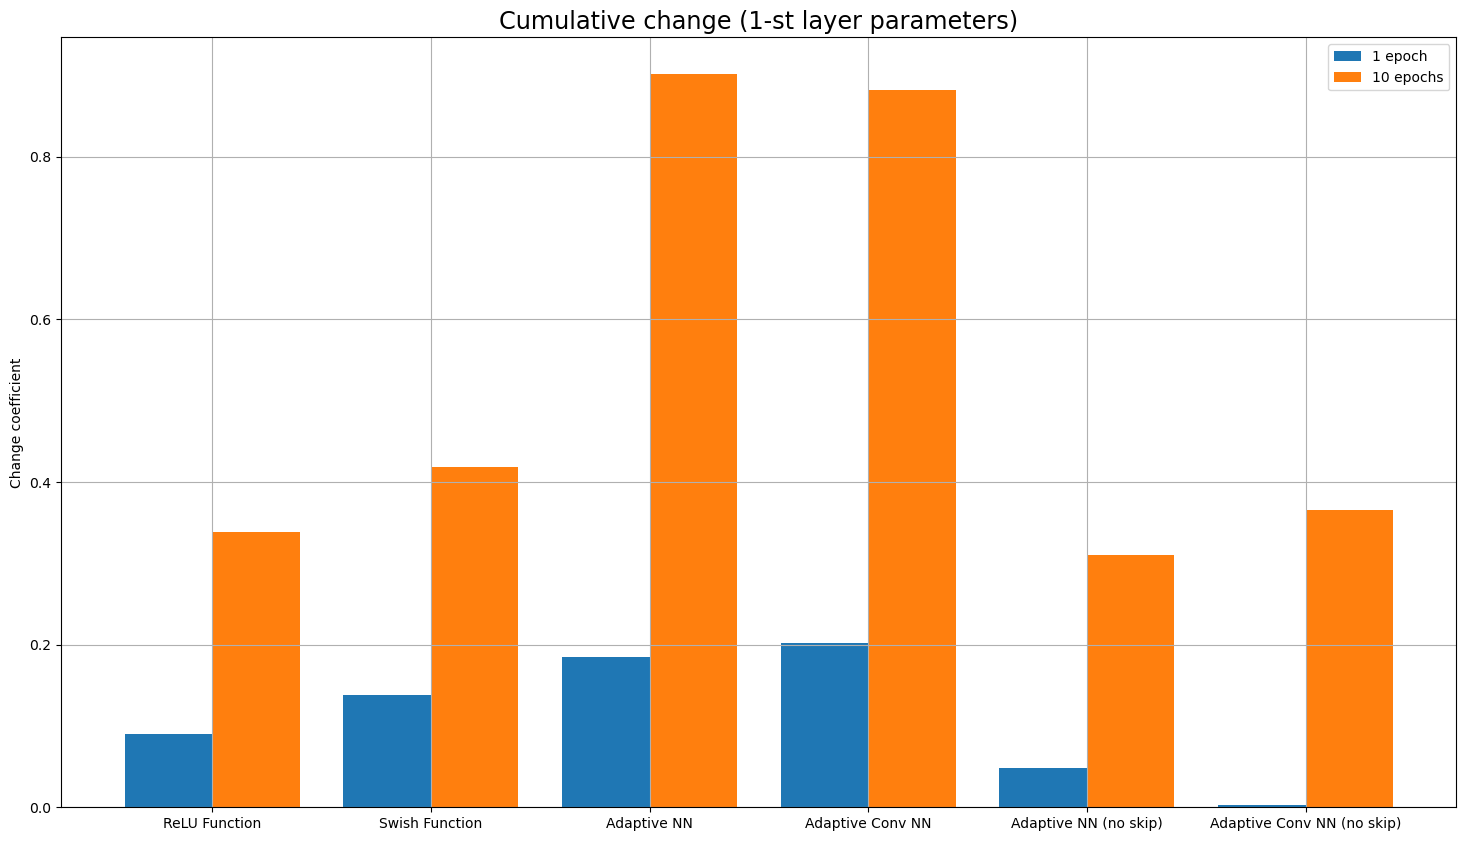

In [78]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()

plt.title("Cumulative change (1-st layer parameters)", fontsize="xx-large")

x = np.arange(6)

y1 = [np.sum(np.abs(initial_static_f_model_w - one_e_static_f_model_w)),
      np.sum(np.abs(initial_adaptive_f_model_w - one_e_adaptive_f_model_w)),
      np.sum(np.abs(initial_adaptive_nn_model_w - one_e_adaptive_nn_model_w)),
      np.sum(np.abs(initial_adaptive_conv_nn_model_w - one_e_adaptive_conv_nn_model_w)),
      np.sum(np.abs(initial_adaptive_nn_model_w_noskip - one_e_adaptive_nn_model_w_noskip)),
      np.sum(np.abs(initial_adaptive_conv_nn_model_w_noskip - one_e_adaptive_conv_nn_model_w_noskip))]

y2 = [np.sum(np.abs(initial_static_f_model_w - ten_e_static_f_model_w)),
      np.sum(np.abs(initial_adaptive_f_model_w - ten_e_adaptive_f_model_w)),
      np.sum(np.abs(initial_adaptive_nn_model_w - ten_e_adaptive_nn_model_w)),
      np.sum(np.abs(initial_adaptive_conv_nn_model_w - ten_e_adaptive_conv_nn_model_w)),
      np.sum(np.abs(initial_adaptive_nn_model_w_noskip - ten_e_adaptive_nn_model_w_noskip)),
      np.sum(np.abs(initial_adaptive_conv_nn_model_w_noskip - ten_e_adaptive_conv_nn_model_w_noskip))]

w = 0.4

plt.ylabel("Change coefficient")
ax.bar(x - w/2, y1, width = w, label="1 epoch")
ax.bar(x + w/2, y2, width = w, label="10 epochs")

plt.xticks([r for r in range(len(y1))], 
        ['ReLU Function', 'Swish Function', 'Adaptive NN',
     'Adaptive Conv NN', 'Adaptive NN (no skip)', 'Adaptive Conv NN (no skip)'])

plt.legend()
plt.grid()
plt.show()

In [82]:
save_data("ReLU f", initial_static_f_model_w,  one_e_static_f_model_w, ten_e_static_f_model_w)
save_data("Swish f", initial_adaptive_f_model_w,  one_e_adaptive_f_model_w, ten_e_adaptive_f_model_w)
save_data("Adaptive NN", initial_adaptive_nn_model_w,  one_e_adaptive_nn_model_w, ten_e_adaptive_nn_model_w)
save_data("Adaptive Conv NN", initial_adaptive_conv_nn_model_w,  one_e_adaptive_conv_nn_model_w, ten_e_adaptive_conv_nn_model_w)
save_data("Adaptive NN (no skip)", initial_adaptive_nn_model_w_noskip,  one_e_adaptive_nn_model_w_noskip, ten_e_adaptive_nn_model_w_noskip)
save_data("Adaptive Conv NN (no skip)", initial_adaptive_conv_nn_model_w_noskip,  one_e_adaptive_conv_nn_model_w_noskip, ten_e_adaptive_conv_nn_model_w_noskip)

In [83]:
workbook.close()